
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector, ColumnTransformer
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from plotnine import ggplot, aes, geom_line, geom_abline, labs, coord_flip, theme, geom_bar
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import cohen_kappa_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
df = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [ ]:
df.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [ ]:
df['restecg'] = df['restecg'].astype(str)
df['cp'] = df['cp'].astype(str)

In [ ]:
X = df.drop(['cp'],axis=1)
y=df['cp']
y = y.astype(str)

In [ ]:
y.value_counts()

0    128
2     81
1     44
3     20
Name: cp, dtype: int64

In [ ]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [ ]:
knn= KNeighborsClassifier()

my_pipeline = Pipeline(
    [('preprocessing',ct),('KNN',knn)]
)

neighbors = {'KNN__n_neighbors':[2,5,10,25,50, 100, 200]}

gscv = GridSearchCV(my_pipeline, neighbors, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

results = pd.DataFrame(data = {"neighbors": [2,5,10,25,50, 100, 200], "KNN Scores": gscv_fitted.cv_results_['mean_test_score']})
results

,neighbors,KNN Scores
0,2,0.414613
1,5,0.483906
2,10,0.513131
3,25,0.545926
4,50,0.542290
5,100,0.535017
6,200,0.468822


In [ ]:
det = DecisionTreeClassifier()

my_pipeline = Pipeline(
    [('preprocessing',ct),('DecTrees',det)]
)

neighbors = {'DecTrees__min_impurity_decrease':[0.001,0.01,0.05,0.1,0.5]}

gscv = GridSearchCV(my_pipeline, neighbors, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

results = pd.DataFrame(data = {"MinImpurityDecrease": [0.001,0.01,0.05,0.1,0.5], "DT Scores": gscv_fitted.cv_results_['mean_test_score']})
results

,MinImpurityDecrease,DT Scores
0,0.001,0.370101
1,0.010,0.498451
2,0.050,0.575219
3,0.100,0.436094
4,0.500,0.468822


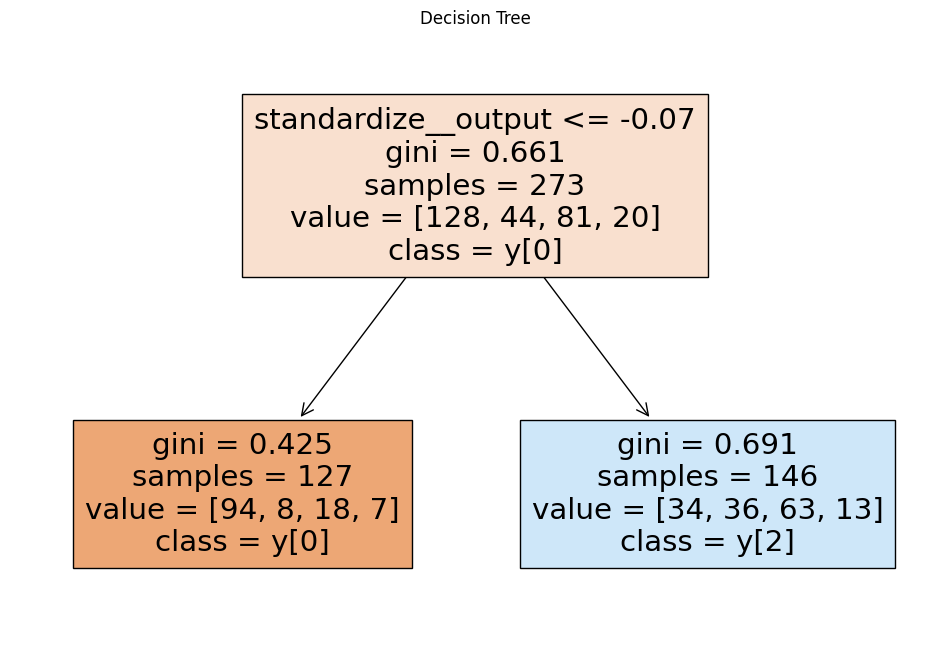

In [ ]:
det = DecisionTreeClassifier(min_impurity_decrease = 0.05)

my_det_pipeline = Pipeline(
    [('preprocessing',ct),('DecTrees',det)]
)

fitted_det_pipeline=my_det_pipeline.fit(X, y)
# Extract the decision tree model from the pipeline
decision_tree_model = fitted_det_pipeline.named_steps['DecTrees']

feature_names = fitted_det_pipeline.named_steps['preprocessing'].get_feature_names_out()


# Plot the decision tree
plt.figure(figsize=(12, 8))  # Adjust the size as needed
plot_tree(decision_tree_model, filled=True, feature_names=feature_names, class_names=True)
plt.title("Decision Tree")
plt.show()

In [ ]:
lda= LinearDiscriminantAnalysis()

my_lr_pipeline = Pipeline(
    [('preprocessing',ct),('LDA',lda)]
)

fitted_lr_pipeline=my_lr_pipeline.fit(X, y)

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [ ]:
df['cp_is_0'] = df['cp'].apply(lambda x: 1 if x=='0' else 0)
df['cp_is_1'] = df['cp'].apply(lambda x: 1 if x=='1' else 0)
df['cp_is_2'] = df['cp'].apply(lambda x: 1 if x=='2' else 0)
df['cp_is_3'] = df['cp'].apply(lambda x: 1 if x=='3' else 0)

In [ ]:
X = df.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'],axis=1)
y=df['cp_is_3']

In [ ]:
y.value_counts()

0    253
1     20
Name: cp_is_3, dtype: int64

In [ ]:
lr = LogisticRegression()

my_lr_pipeline = Pipeline(
    [('preprocessing',ct),('Log',lr)]
)

fitted_lr_pipeline=my_lr_pipeline.fit(X, y)

scores = cross_val_score(fitted_lr_pipeline, X, y, cv=5, scoring='f1')
scores.mean()

0.0

In [ ]:
X = df.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'],axis=1)
y=df['cp_is_2']
lr = LogisticRegression()

my_lr_pipeline = Pipeline(
    [('preprocessing',ct),('Log',lr)]
)

fitted_lr_pipeline=my_lr_pipeline.fit(X, y)

scores = cross_val_score(fitted_lr_pipeline, X, y, cv=5, scoring='f1')
scores.mean()

0.13355825461088616

In [ ]:
X = df.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'],axis=1)
y=df['cp_is_1']
lr = LogisticRegression()

my_lr_pipeline = Pipeline(
    [('preprocessing',ct),('Log',lr)]
)

fitted_lr_pipeline=my_lr_pipeline.fit(X, y)

scores = cross_val_score(fitted_lr_pipeline, X, y, cv=5, scoring='f1')
scores.mean()

0.0

In [ ]:
X = df.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'],axis=1)
y=df['cp_is_0']
lr = LogisticRegression()

my_lr_pipeline = Pipeline(
    [('preprocessing',ct),('Log',lr)]
)

fitted_lr_pipeline=my_lr_pipeline.fit(X, y)

scores = cross_val_score(fitted_lr_pipeline, X, y, cv=5, scoring='f1')
scores.mean()

0.6460435579422921

OvR was best at distinguishing class 1, which makes sense, because it was the most prevalent class. The probabilities do not add up to 1. This is because the four models do not connect to eachother at all. You could run all four of the models and choose the one with the highest probability, but it's not a whatever % chance it's class 0, it's just a whatever % chance it's class 0 over everything else.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

0 and 1

In [ ]:
filter = ((df['cp'] == '0') | (df['cp']=='1'))
newdf = df[filter]

X = newdf.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'],axis=1)
y=newdf['cp']

In [ ]:
fitted_lr_pipeline=my_lr_pipeline.fit(X, y)

scores = cross_val_score(fitted_lr_pipeline, X, y, cv=5, scoring='roc_auc')
scores.mean()

0.8390641025641024

0 and 2

In [ ]:
filter = ((df['cp'] == '0') | (df['cp']=='2'))
newdf = df[filter]

X = newdf.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'],axis=1)
y=newdf['cp']

fitted_lr_pipeline=my_lr_pipeline.fit(X, y)

scores = cross_val_score(fitted_lr_pipeline, X, y, cv=5, scoring='roc_auc')
scores.mean()

0.7459015837104073

0 and 3

In [ ]:
filter = ((df['cp'] == '0') | (df['cp']=='3'))
newdf = df[filter]

X = newdf.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'],axis=1)
y=newdf['cp']

fitted_lr_pipeline=my_lr_pipeline.fit(X, y)

scores = cross_val_score(fitted_lr_pipeline, X, y, cv=5, scoring='roc_auc')
scores.mean()

0.7373076923076923

OvO was best at distinguishing between 0 and 1

We reported ROC-AUC because it is a better metric for seeing how good a model is at distinguishing between two categories

The probabilities do not add up to 1, because the models do not communicate with eachother. You can only see the likelihood of it being one instead of another.

You would have to run 6 regressions to do all of the pairs

You could use these results to arrive at one final class prediction by using them as weighted votes, but in reality you let scikit learn do OvO for you.